In [1]:
from pyspark.sql import SparkSession
import sqlite3 

spark = SparkSession.builder.appName(name='BDA_AI')\
    .config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.34.0')\
    .getOrCreate()

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

:: loading settings :: url = jar:file:/home/derry/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/derry/.ivy2/cache
The jars for the packages stored in: /home/derry/.ivy2/jars
org.xerial#sqlite-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d8666378-5688-4b8b-8aec-4e00463a0eda;1.0
	confs: [default]
	found org.xerial#sqlite-jdbc;3.34.0 in central
:: resolution report :: resolve 204ms :: artifacts dl 5ms
	:: modules in use:
	org.xerial#sqlite-jdbc;3.34.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-d8666378-5688-4b8b-8aec-4e00463a0eda
	confs: [default]
	0

23/01/26 03:22:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


We create the pyspark dataframe by using the sqlite jar file, and concatenate every dataframe together

In [2]:
###
### Load Aldi database
###
aldi_df1 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Aldi_0_500.db').load()
aldi_df2 = spark.read.format('jdbc')\
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Aldi_501_1000.db').load()
aldi_df3 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Aldi_1001_1500.db').load()
aldi_df4 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Aldi_1501_1800.db').load()
aldi_df5 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Aldi_1801_2000.db').load()
###
### Load Tesco database
###
tesco_df1 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Tesco_0_500.db').load()
tesco_df2 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Tesco_501_1000.db').load()
tesco_df3 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Tesco_1001_2000.db').load()
tesco_df4 = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='products',
                 url='jdbc:sqlite:Tesco_2001_2500.db').load()


### concatenate dataframe
aldi_df = aldi_df1.union(aldi_df2)\
                .union(aldi_df3)\
                .union(aldi_df4)\
                .union(aldi_df5)\

tesco_df = tesco_df1.union(tesco_df2)\
                .union(tesco_df3)\
                .union(tesco_df4)

In [3]:
print(f"Aldi dataframe rows count: {aldi_df.count()}")
print(f"tesco dataframe rows count: {tesco_df.count()}")

Aldi dataframe rows count: 7531
tesco dataframe rows count: 8071


# Unsupervised learning on unit price

In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import json, re

Custom functions for parse the nutrition column from database

In [5]:
import ast

def get_kj(e) -> int:
    literals = ast.literal_eval(e)
    if len(literals) < 1 : return 0
    for _ in literals:
        
        if (_['name'] == "Energy"):
            try:
                parts = _["perServing"].split("/")
                found = re.search('(.+?)kJ', parts[0]).group(1)
                return int(found)
            except AttributeError:
                """
                error occurs when 1. perServing is None, 2. perComp: is not formatted
                """
                return 0
        

def get_calcium(e) -> int:
    literals = ast.literal_eval(e)
    if len(literals) < 1 : return 0
    for _ in literals:
        
        if (_['name'] == "Calcium"):
            try:
                parts = _["perComp"].split("/")
                found = re.search('(.+?)mg', parts[0]).group(1)
                return int(found)
            except AttributeError:
                """
                similar error to get kj
                """
                return 0

def get_protein(e) -> float:
    literals = ast.literal_eval(e)
    if len(literals) < 1 : return 0
    for _ in literals:
        
        if (_['name'] == "Protein"):
            try:
                parts = _["perComp"].split("/")
                found = re.search('(.+?)g', parts[0]).group(1)
                try:
                    out = float(found)
                    return out
                except ValueError:
                    return 0
            except AttributeError:
                """
                similar error to get kj
                """
                return 0

A basket of goods:

Tesco category
- yogurt
- Jams, Spreads & Honey
- Eggs
- Fresh Milk
- second category: Bread
- Rice
- Frozen Vegetables

Aldi category
- 2nd category: Yogurts
- Butter & Spreads
- Fresh Eggs
- Milk
- 3rd: Bread
- Rice
- Frozen Vegetables

## Tesco products

In [6]:
volume = ["kg", "each", "litre", "kg DR.WT"]
###
### yoghurt
###
tesco_yogurt = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.where(col("third_category") == "Yoghurts")\
.distinct().cache().collect()
            
tesco_yogurt = spark.createDataFrame(tesco_yogurt)
tesco_yogurt_pd = tesco_yogurt.to_pandas_on_spark()
tesco_yogurt_pd['kj'] = tesco_yogurt_pd['nutrition'].apply(get_kj)
tesco_yogurt_pd['calcium'] = tesco_yogurt_pd['nutrition'].apply(get_calcium)
tesco_yogurt_pd['protein'] = tesco_yogurt_pd['nutrition'].apply(get_protein)

tesco_yogurt_pd.dropna(subset=['kj'], inplace=True)
tesco_yogurt_pd.drop(tesco_yogurt_pd[tesco_yogurt_pd['kj'].astype(str) == "0.0"].index)

###
### Jams, spreads etc
###

tesco_jam = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.where(col("third_category") == "Jams, Spreads & Honey")\
.distinct().collect()
            
tesco_jam = spark.createDataFrame(tesco_jam)
tesco_jam_pd = tesco_jam.to_pandas_on_spark()
tesco_jam_pd['kj'] = tesco_jam_pd['nutrition'].apply(get_kj)
tesco_jam_pd['calcium'] = tesco_jam_pd['nutrition'].apply(get_calcium)
tesco_jam_pd['protein'] = tesco_jam_pd['nutrition'].apply(get_protein)

tesco_jam_pd.dropna(subset=['kj'], inplace=True)
tesco_jam_pd.drop(tesco_jam_pd[tesco_jam_pd['kj'].astype(str) == "0.0"].index)

###
### eggs
###

tesco_egg = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.where(col("third_category") == "Eggs")\
.distinct().collect()
            
tesco_egg = spark.createDataFrame(tesco_egg)
tesco_egg_pd = tesco_egg.to_pandas_on_spark()

###
### Fresh Milk
###

tesco_milk = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.where(col("third_category") == "Fresh Milk")\
.distinct().collect()
            
tesco_milk = spark.createDataFrame(tesco_milk)
tesco_milk_pd = tesco_milk.to_pandas_on_spark()
tesco_milk_pd

###
### Bread
###

tesco_bread = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.where(col("second_category") == "Bread")\
.distinct().collect()
            
tesco_bread = spark.createDataFrame(tesco_bread)
tesco_bread_pd = tesco_bread.to_pandas_on_spark()
tesco_bread_pd

###
### Rice
###

tesco_rice = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.where(col("third_category") == "Rice")\
.distinct().collect()
            
tesco_rice = spark.createDataFrame(tesco_rice)
tesco_rice_pd = tesco_rice.to_pandas_on_spark()
tesco_rice_pd

###
### Frozen Vegetables
###

tesco_veggie = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.where(col("third_category") == "Frozen Vegetables")\
.distinct().collect()
            
tesco_veggie = spark.createDataFrame(tesco_veggie)
tesco_veggie_pd = tesco_veggie.to_pandas_on_spark()

###
### full
###
tesco_full = tesco_df.select("product_name", "selling_price", col("nutrition"), "unit_price", "unit_volume", "second_category", "third_category")\
.where(col("unit_volume").isNotNull())\
.where(col("unit_price").isNotNull())\
.where(col("unit_volume").isin(volume) == True)\
.distinct().collect()
            
tesco_full = spark.createDataFrame(tesco_full)
tesco_full_pspd = tesco_full.to_pandas_on_spark()

/home/derry/.local/lib/python3.10/site-packages/pyspark/sql/dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a

## Aldi products

In [7]:
def calculate_unit_price(ind_price, ind_volume):
    # filter unstructure data
    foundx = ind_volume.str.find('x')
    found_pack = ind_volume.str.find('ack')
    if foundx != -1 or found_pack != -1:
        return 0
    
    # kg
    if ind_volume.find('kg'):
        try:
            kg = re.search('(.+?)kg', parts[0]).group(1)
            return float(ind_price) / float(kg)
        except ValueError:
            return 0
    
    # L
    if ind_volume.find('L'):
        try:
            L = re.search('(.+?)L', parts[0]).group(1)
            return float(ind_price) / float(L)
        except ValueError:
            return 0
    
    # g
    if ind_volume.find('g'):
        try:
            g = re.search('(.+?)g', parts[0]).group(1)
            per_g = 1000 / float(g)
            return float(ind_price) / per_g
        except ValueError:
            return 0
    
    # ml
    if ind_volume.find('ml'):
        try:
            ml = re.search('(.+?)ml', parts[0]).group(1)
            per_ml = 1000 / float(ml)
            return float(ind_price) / per_ml
        except ValueError:
            return 0
        
    return 0

def calc_per_kg(ind_volume) -> float:
    # filter unstructure data
    foundx = ind_volume.find('x')
    found_pack = ind_volume.find('ack')
    if foundx != -1 or found_pack != -1:
        return 0
    
    # g
    if ind_volume.find('g') != -1:
        try:
            g = re.search('(.+?)g', ind_volume).group(1)
            per_g = float(g) / 1000
            return per_g
        except (ValueError, AttributeError):
            return 0
    
    # kg
    if ind_volume.find('kg') != -1:
        try:
            kg = re.search('(.+?)kg', ind_volume).group(1)
            return float(kg)
        except (ValueError, AttributeError):
            return 0
    
    # L
    if ind_volume.find('L') != -1:
        try:
            L = re.search('(.+?)L', ind_volume).group(1)
            return float(L)
        except (ValueError, AttributeError):
            return 0
    
    
    # ml
    if ind_volume.find('ml') != -1:
        try:
            ml = re.search('(.+?)ml', ind_volume).group(1)
            per_ml = float(ml) / 1000
            return per_ml
        except (ValueError, AttributeError):
            return 0
        
    return 0

In [8]:
import numpy as np
###
### yoghurt
###

aldi_yogurt = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.where(col("second_category") == "Yogurts")\
.distinct().collect()
            
aldi_yogurt = spark.createDataFrame(aldi_yogurt)
aldi_yogurt_pd = aldi_yogurt.to_pandas_on_spark()

aldi_yogurt_pd['per_kg'] = aldi_yogurt_pd['selling_volume'].apply(calc_per_kg)
aldi_yogurt_pd['unit_price'] = aldi_yogurt_pd['selling_price'] / aldi_yogurt_pd['per_kg']
aldi_yogurt_pd['unit_price'] = aldi_yogurt_pd['unit_price'].replace([np.inf, -np.inf], np.nan)
aldi_yogurt_pd.dropna(subset=['unit_price', 'selling_volume'], inplace=True)


###
### Butter & Spreads
###

aldi_butter = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.where(col("third_category") == "Butter & Spreads")\
.distinct().collect()
            
aldi_butter = spark.createDataFrame(aldi_butter)
aldi_butter_pd = aldi_butter.to_pandas_on_spark()

aldi_butter_pd['per_kg'] = aldi_butter_pd['selling_volume'].apply(calc_per_kg)
aldi_butter_pd['unit_price'] = aldi_butter_pd['selling_price'] / aldi_butter_pd['per_kg']
aldi_butter_pd['unit_price'] = aldi_butter_pd['unit_price'].replace([np.inf, -np.inf], np.nan)
aldi_butter_pd.dropna(subset=['unit_price', 'selling_volume'], inplace=True)


###
### Fresh Eggs
###

def get_egg(e) -> float:
    parts = e.split(" ")
    return float(parts[0])

aldi_eggs = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.where(col("third_category") == "Fresh Eggs")\
.distinct().collect()
            
aldi_eggs = spark.createDataFrame(aldi_eggs)

aldi_eggs_df = aldi_eggs.to_pandas_on_spark()
aldi_eggs_df['per_kg'] = aldi_eggs_df['selling_volume'].apply(get_egg)
aldi_eggs_df['unit_price'] = aldi_eggs_df['selling_price'] / aldi_eggs_df['per_kg']
aldi_eggs_df['unit_price'] = aldi_eggs_df['unit_price'].replace([np.inf, -np.inf], np.nan)
aldi_eggs_df.dropna(subset=['unit_price', 'selling_volume'], inplace=True)


###
### Milk
###

aldi_milk = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.where(col("third_category") == "Milk")\
.distinct().collect()
            
aldi_milk = spark.createDataFrame(aldi_milk)
aldi_milk_df = aldi_milk.to_pandas_on_spark()

aldi_milk_df['per_kg'] = aldi_milk_df['selling_volume'].apply(calc_per_kg)
aldi_milk_df['unit_price'] = aldi_milk_df['selling_price'] / aldi_milk_df['per_kg']
# aldi_milk_df['unit_price'] = aldi_milk_df['unit_price'].replace([np.inf, -np.inf], np.nan)
# aldi_milk_df.dropna(subset=['unit_price', 'selling_volume'], inplace=True)


###
### Bread
###

aldi_bread = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.where(col("third_category") == "Bread")\
.distinct().collect()
            
aldi_bread = spark.createDataFrame(aldi_bread)
aldi_bread_df = aldi_bread.to_pandas_on_spark()

aldi_bread_df['per_kg'] = aldi_bread_df['selling_volume'].apply(calc_per_kg)
aldi_bread_df['unit_price'] = aldi_bread_df['selling_price'] / aldi_bread_df['per_kg']
aldi_bread_df['unit_price'] = aldi_bread_df['unit_price'].replace([np.inf, -np.inf], np.nan)
aldi_bread_df.dropna(subset=['unit_price', 'selling_volume'], inplace=True)


###
### Rice
###

aldi_rice = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.where(col("third_category") == "Rice")\
.distinct().collect()
            
aldi_rice = spark.createDataFrame(aldi_rice)
aldi_rice_df = aldi_rice.to_pandas_on_spark()

aldi_rice_df['per_kg'] = aldi_rice_df['selling_volume'].apply(calc_per_kg)
aldi_rice_df['unit_price'] = aldi_rice_df['selling_price'] / aldi_rice_df['per_kg']
aldi_rice_df['unit_price'] = aldi_rice_df['unit_price'].replace([np.inf, -np.inf], np.nan)
aldi_rice_df.dropna(subset=['unit_price', 'selling_volume'], inplace=True)


###
### Frozen Vegetables
###

aldi_veggie = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.where(col("third_category") == "Frozen Vegetables")\
.distinct().collect()
            
aldi_veggie = spark.createDataFrame(aldi_veggie)
aldi_veggie_df = aldi_veggie.to_pandas_on_spark()

aldi_veggie_df['per_kg'] = aldi_veggie_df['selling_volume'].apply(calc_per_kg)
aldi_veggie_df['unit_price'] = aldi_veggie_df['selling_price'] / aldi_veggie_df['per_kg']
aldi_veggie_df['unit_price'] = aldi_veggie_df['unit_price'].replace([np.inf, -np.inf], np.nan)
aldi_veggie_df.dropna(subset=['unit_price', 'selling_volume'], inplace=True)

###
### full
###
aldi_full = aldi_df.select("product_name", col("nutrition"), "selling_price", "selling_volume", "second_category", "third_category")\
.distinct().collect()
            
aldi_full = spark.createDataFrame(aldi_full)
aldi_full_pspd = aldi_full.to_pandas_on_spark()

aldi_full_pspd['per_kg'] = aldi_full_pspd['selling_volume'].apply(calc_per_kg)
aldi_full_pspd['unit_price'] = aldi_full_pspd['selling_price'] / aldi_full_pspd['per_kg']
aldi_full_pspd['unit_price'] = aldi_full_pspd['unit_price'].replace([np.inf, -np.inf], np.nan)
aldi_full_pspd.dropna(subset=['unit_price', 'selling_volume'], inplace=True)
aldi_full = aldi_full_pspd.to_spark()
aldi_full.show()

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------------------+--------------------+-------------+--------------+--------------------+--------------------+------+------------------+
|        product_name|           nutrition|selling_price|selling_volume|     second_category|      third_category|per_kg|        unit_price|
+--------------------+--------------------+-------------+--------------+--------------------+--------------------+------+------------------+
|Irish Diced Turke...|Per 100g serving ...|         3.79|          370g|      Meat & Poultry|              Turkey|  0.37|10.243243243243244|
|Baby Shampoo 500m...|                    |       0.5854|         500ml| Bath, Shower & Soap| Shower, Bath & Soap|   0.5|            1.1708|
|Luxury Milk Choco...|Per 100g: Energy ...|       0.8862|          100g|  Sweets & Chocolate|      Chocolate Bars|   0.1|             8.862|
|Reduced Fat Cocon...|Energy 262kJ, 63k...|         0.95|         400ml|Tins, Cans & Packets|        Tinned Fruit|   0.4|2.3749999999999996|
|Delicatessen

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


## plot against unit price

### Yogurt

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/py

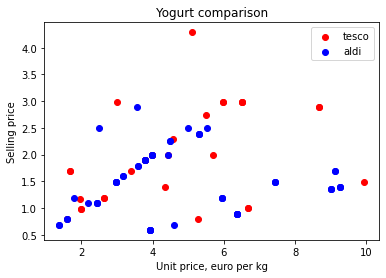

23/01/26 05:58:27 WARN TransportChannelHandler: Exception in connection from Man-x1/172.29.118.233:36661
java.io.IOException: Connection timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:722)
	at io.netty.channel.nio.NioEventLoop.processSelectedK

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

tesco_yogurt_x = tesco_yogurt_pd['unit_price'].astype(float).to_numpy()
tesco_yogurt_y = tesco_yogurt_pd['selling_price'].astype(float).to_numpy()

aldi_yogurt_x = aldi_yogurt_pd['unit_price'].astype(float).to_numpy()
aldi_yogurt_y = aldi_yogurt_pd['selling_price'].astype(float).to_numpy()

# plt.figure(figsize=(10,6))
plt.scatter(tesco_yogurt_x, tesco_yogurt_y, c='r', label = "tesco" )
plt.scatter(aldi_yogurt_x, aldi_yogurt_y, c='b', label = "aldi" )

# Set x and y axes labels
plt.xlabel('Unit price, euro per kg')
plt.ylabel('Selling price')

plt.title('Yogurt comparison')
plt.legend()
plt.show()

In [10]:
print("Yogurt comparison")
print(tesco_yogurt_pd[['unit_price', 'selling_price']].astype(float).describe())
print(aldi_yogurt_pd[['unit_price', 'selling_price']].astype(float).describe())

Yogurt comparison


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


       unit_price  selling_price
count   31.000000      31.000000
mean     4.678710       1.995161
std      2.222693       0.880708
min      1.580000       0.790000
25%      2.640000       1.190000
50%      4.420000       1.890000
75%      6.500000       2.890000
max      9.930000       4.290000


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

       unit_price  selling_price
count   59.000000      59.000000
mean     4.829138       1.466271
std      2.290859       0.591182
min      1.380000       0.590000
25%      3.180000       0.890000
50%      3.980000       1.490000
75%      6.357143       1.890000
max      9.266667       2.890000


### Butter & spread

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/py

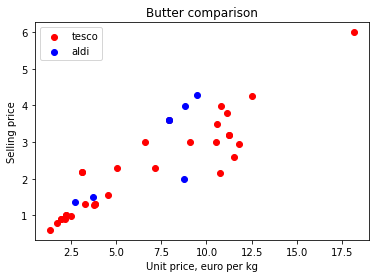

In [11]:
tesco_butter_x = tesco_jam_pd['unit_price'].astype(float).to_numpy()
tesco_butter_y = tesco_jam_pd['selling_price'].astype(float).to_numpy()

aldi_butter_x = aldi_butter_pd['unit_price'].astype(float).to_numpy()
aldi_butter_y = aldi_butter_pd['selling_price'].astype(float).to_numpy()

# plt.figure(figsize=(10,6))
plt.scatter(tesco_butter_x, tesco_butter_y, c='r', label = "tesco" )
plt.scatter(aldi_butter_x, aldi_butter_y, c='b', label = "aldi" )

# Set x and y axes labels
plt.xlabel('Unit price, euro per kg')
plt.ylabel('Selling price')

plt.title('Butter comparison')
plt.legend()
plt.show()

In [12]:
print("Butter and bread comparison")
print(tesco_jam_pd[['unit_price', 'selling_price']].astype(float).describe())
print(aldi_butter_pd[['unit_price', 'selling_price']].astype(float).describe())

Butter and bread comparison


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


       unit_price  selling_price
count   31.000000      31.000000
mean     6.695806       2.287742
std      4.444220       1.291474
min      1.320000       0.600000
25%      2.480000       1.000000
50%      5.070000       2.190000
75%     10.780000       3.190000
max     18.180000       6.000000


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

       unit_price  selling_price
count    7.000000       7.000000
mean     7.034912       2.898571
std      2.682440       1.244393
min      2.700000       1.350000
25%      3.725000       1.490000
50%      7.907489       3.590000
75%      8.788546       3.990000
max      9.449339       4.290000


### Eggs

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: Fut

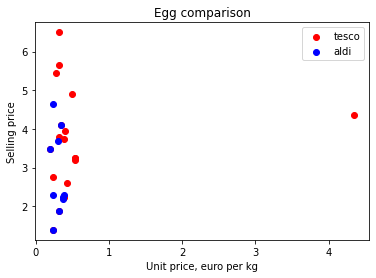

In [13]:
tesco_egg_x = tesco_egg_pd['unit_price'].astype(float).to_numpy()
tesco_egg_y = tesco_egg_pd['selling_price'].astype(float).to_numpy()

aldi_egg_x = aldi_eggs_df['unit_price'].astype(float).to_numpy()
aldi_egg_y = aldi_eggs_df['selling_price'].astype(float).to_numpy()

# plt.figure(figsize=(10,6))
plt.scatter(tesco_egg_x, tesco_egg_y, c='r', label = "tesco" )
plt.scatter(aldi_egg_x, aldi_egg_y, c='b', label = "aldi" )

# Set x and y axes labels
plt.xlabel('Unit price, euro per kg')
plt.ylabel('Selling price')

plt.title('Egg comparison')
plt.legend()
plt.show()

In [14]:
print("Egg comparison")
print(tesco_egg_pd[['unit_price', 'selling_price']].astype(float).describe())
print(aldi_eggs_df[['unit_price', 'selling_price']].astype(float).describe())

Egg comparison
       unit_price  selling_price
count   19.000000      19.000000
mean     0.576316       3.618421
std      0.919778       1.339964
min      0.190000       1.390000
25%      0.310000       2.590000
50%      0.380000       3.490000
75%      0.490000       4.350000
max      4.350000       6.500000


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

       unit_price  selling_price
count   10.000000      10.000000
mean     0.297206       2.822000
std      0.069854       1.072948
min      0.193889       1.390000
25%      0.231667       2.190000
50%      0.307500       2.290000
75%      0.365000       3.690000
max      0.381667       4.650000


### Milk

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: Fut

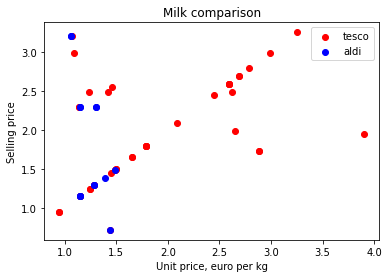

In [15]:
tesco_milk_x = tesco_milk_pd['unit_price'].astype(float).to_numpy()
tesco_milk_y = tesco_milk_pd['selling_price'].astype(float).to_numpy()

aldi_milk_x = aldi_milk_df['unit_price'].astype(float).to_numpy()
aldi_milk_y = aldi_milk_df['selling_price'].astype(float).to_numpy()

# plt.figure(figsize=(10,6))
plt.scatter(tesco_milk_x, tesco_milk_y, c='r', label = "tesco" )
plt.scatter(aldi_milk_x, aldi_milk_y, c='b', label = "aldi" )

# Set x and y axes labels
plt.xlabel('Unit price, euro per kg')
plt.ylabel('Selling price')

plt.title('Milk comparison')
plt.legend()
plt.show()

In [16]:
print("Milk comparison")
print(tesco_milk_pd[['unit_price', 'selling_price']].astype(float).describe())
print(aldi_milk_df[['unit_price', 'selling_price']].astype(float).describe())

Milk comparison
       unit_price  selling_price
count   43.000000      43.000000
mean     1.893256       1.985814
std      0.746681       0.666163
min      0.950000       0.720000
25%      1.250000       1.490000
50%      1.650000       1.790000
75%      2.590000       2.590000
max      3.900000       3.250000


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


       unit_price  selling_price
count   14.000000      14.000000
mean     1.242177       1.799286
std      0.136375       0.789289
min      1.066667       0.720000
25%      1.145000       1.150000
50%      1.150000       1.390000
75%      1.308571       2.290000
max      1.490000       3.200000


### Bread

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: Fut

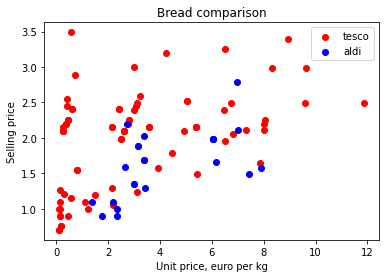

In [17]:
tesco_bread_x = tesco_bread_pd['unit_price'].astype(float).to_numpy()
tesco_bread_y = tesco_bread_pd['selling_price'].astype(float).to_numpy()

aldi_bread_x = aldi_bread_df['unit_price'].astype(float).to_numpy()
aldi_bread_y = aldi_bread_df['selling_price'].astype(float).to_numpy()

# plt.figure(figsize=(10,6))
plt.scatter(tesco_bread_x, tesco_bread_y, c='r', label = "tesco" )
plt.scatter(aldi_bread_x, aldi_bread_y, c='b', label = "aldi" )

# Set x and y axes labels
plt.xlabel('Unit price, euro per kg')
plt.ylabel('Selling price')

plt.title('Bread comparison')
plt.legend()
plt.show()

In [18]:
print("Bread comparison")
print(tesco_bread_pd[['unit_price', 'selling_price']].astype(float).describe())
print(aldi_bread_df[['unit_price', 'selling_price']].astype(float).describe())

Bread comparison
       unit_price  selling_price
count   81.000000      81.000000
mean     3.060370       1.994321
std      2.907156       0.667428
min      0.120000       0.700000
25%      0.450000       1.550000
50%      2.490000       2.150000
75%      5.040000       2.400000
max     11.860000       3.490000


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

       unit_price  selling_price
count   22.000000      22.000000
mean     4.169336       1.618955
std      2.065703       0.482667
min      1.362500       0.890000
25%      2.650000       1.290000
50%      3.380000       1.590000
75%      6.030303       1.990000
max      7.885500       2.790000


### Rice

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: Fut

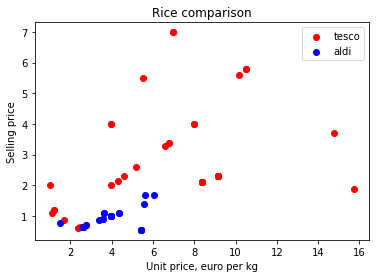

In [19]:
tesco_rice_x = tesco_rice_pd['unit_price'].astype(float).to_numpy()
tesco_rice_y = tesco_rice_pd['selling_price'].astype(float).to_numpy()

aldi_rice_x = aldi_rice_df['unit_price'].astype(float).to_numpy()
aldi_rice_y = aldi_rice_df['selling_price'].astype(float).to_numpy()

# plt.figure(figsize=(10,6))
plt.scatter(tesco_rice_x, tesco_rice_y, c='r', label = "tesco" )
plt.scatter(aldi_rice_x, aldi_rice_y, c='b', label = "aldi" )

# Set x and y axes labels
plt.xlabel('Unit price, euro per kg')
plt.ylabel('Selling price')

plt.title('Rice comparison')
plt.legend()
plt.show()

In [20]:
print("Rice comparison")
print(tesco_rice_pd[['unit_price', 'selling_price']].astype(float).describe())
print(aldi_rice_df[['unit_price', 'selling_price']].astype(float).describe())

Rice comparison
       unit_price  selling_price
count   46.000000      46.000000
mean     6.544565       2.640870
std      3.498432       1.669692
min      1.000000       0.590000
25%      3.560000       1.890000
50%      6.990000       2.290000
75%      9.160000       3.390000
max     15.750000       6.990000


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

       unit_price  selling_price
count   27.000000      27.000000
mean     4.010212       0.927037
std      1.133110       0.309898
min      1.500000       0.540000
25%      3.400000       0.650000
50%      3.960000       0.990000
75%      5.400000       1.090000
max      6.035714       1.690000


### Frozen Vegetables

/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: Fut

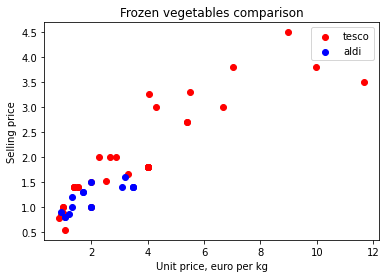

In [21]:
tesco_veggie_x = tesco_veggie_pd['unit_price'].astype(float).to_numpy()
tesco_veggie_y = tesco_veggie_pd['selling_price'].astype(float).to_numpy()

aldi_veggie_x = aldi_veggie_df['unit_price'].astype(float).to_numpy()
aldi_veggie_y = aldi_veggie_df['selling_price'].astype(float).to_numpy()

# plt.figure(figsize=(10,6))
plt.scatter(tesco_veggie_x, tesco_veggie_y, c='r', label = "tesco" )
plt.scatter(aldi_veggie_x, aldi_veggie_y, c='b', label = "aldi" )

# Set x and y axes labels
plt.xlabel('Unit price, euro per kg')
plt.ylabel('Selling price')

plt.title('Frozen vegetables comparison')
plt.legend()
plt.show()

In [22]:
print("Frozen vegetables comparison")
print(tesco_veggie_pd[['unit_price', 'selling_price']].astype(float).describe())
print(aldi_veggie_df[['unit_price', 'selling_price']].astype(float).describe())

Frozen vegetables comparison
       unit_price  selling_price
count   36.000000      36.000000
mean     3.585556       1.976389
std      2.654408       0.977671
min      0.870000       0.540000
25%      1.390000       1.390000
50%      2.860000       1.800000
75%      4.060000       2.700000
max     11.670000       4.490000


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

       unit_price  selling_price
count   16.000000       16.00000
mean     2.059441        1.16875
std      0.956500        0.26688
min      0.917526        0.79000
25%      1.214286        0.89000
50%      1.720000        1.19000
75%      3.088889        1.39000
max      3.475000        1.59000


## Predict the unit_price with classifier

- use string indexer for 2 product categories
- use unit_price

predict selling price

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, PolynomialExpansion

second_category_indexer = StringIndexer(inputCol="second_category", outputCol="second_category_index")
third_category_indexer = StringIndexer(inputCol="third_category", outputCol="third_category_index")
assemble = VectorAssembler(inputCols=['unit_price','second_category_index','third_category_index'], outputCol='features')


pipeline = Pipeline(stages=[second_category_indexer, third_category_indexer, assemble])
aldi_prepared_data = pipeline.fit(aldi_full).transform(aldi_full)

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    model = KMeans(featuresCol='features', k=i)
    kmeans = model.fit(aldi_prepared_data)
    output= kmeans.transform(aldi_prepared_data)
    cost[i] = kmeans.summary.trainingCost

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

23/01/26 03:23:49 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

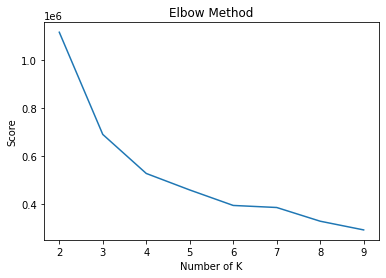

In [25]:
import pandas as pd
import pylab as pl

df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of K')
pl.ylabel('Score')
pl.title('Elbow Method')
pl.show()

At k = 5 starts to slowing going down

In [26]:
kmeans = KMeans(featuresCol='features', k=5)
model = kmeans.fit(aldi_prepared_data)

prediction = model.transform(aldi_prepared_data)
prediction.show(5,0)

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

+------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+--------------+--------------------+-------------------+------+------------------+---------------------+--------------------+-----------------------------+----------+
|product_name                                                |nutrition                                                                                                                                                        |selling_price|selling_volume|second_category     |third_category     |per_kg|unit_price        |second_category_index|third_category_index|features                     |prediction|
+------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

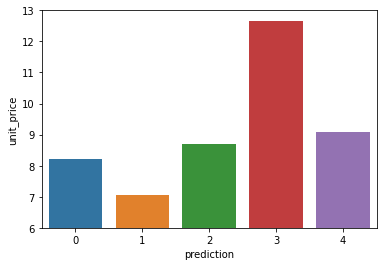

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = prediction.select('unit_price', 'third_category','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

g = sns.barplot(x='prediction', y='unit_price', data=avg_df)
g.set_ylim(6, 13)
plt.show()

In [28]:
prediction.select("product_name", "unit_price", "third_category", "prediction").where(col("prediction") == 1).show(truncate=False)

+----------------------------------------------------------------+------------------+----------------------------+----------+
|product_name                                                    |unit_price        |third_category              |prediction|
+----------------------------------------------------------------+------------------+----------------------------+----------+
|Cheesy Singles Light 200g Emporium                              |2.9499999999999997|Processed Cheese            |1         |
|Bake At Home Stone Baguette White 250g Village Bakery           |5.16              |Part Baked Breads           |1         |
|Pickled Sliced Beetroot 710g (462g Drained) The Deli            |1.3380281690140845|Pickled Vegetables          |1         |
|Light Mayonnaise 504g Bramwells                                 |2.5595238095238098|Mayonnaise                  |1         |
|Pickled Baby Beetroot 710g (462g Drained) The Deli              |1.3380281690140845|Pickled Vegetables          |1   

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [29]:
prediction.select("selling_price", "third_category", "prediction")\
.where(col("prediction") == 4)\
.groupBy("third_category").count()\
.show()

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

+--------------------+-----+
|      third_category|count|
+--------------------+-----+
| Shower, Bath & Soap|   14|
| Cooked Sliced Meats|   10|
|   Frozen Vegetables|   16|
|              Crisps|   14|
|                Milk|   14|
|  Juices & Smoothies|   10|
| Sandwiches & Snacks|   13|
|     Cheddar Cheeses|   12|
|                 Ham|   12|
|                 Oil|   11|
|   Continental Meats|   14|
|            Dog Food|   17|
|       Sliced Cheese|   14|
|          Cooked Ham|   15|
|      Air Fresheners|   14|
|Frozen Fish & Sea...|   13|
|    Squash & Cordial|   10|
|Frozen Potato Pro...|   11|
|                Pork|   15|
|   Jams & Marmalades|   12|
+--------------------+-----+
only showing top 20 rows



/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [30]:
foodList = ['Bread', 'Milk', 'Butter & Spreads', 'Rice']
prediction.select("product_name", "third_category","prediction").where(col("third_category").isin(foodList))\
.orderBy(desc("prediction")).show()

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated a

+--------------------+----------------+----------+
|        product_name|  third_category|prediction|
+--------------------+----------------+----------+
|Skimmed Milk 1l C...|            Milk|         4|
|Irish Fresh Milk ...|            Milk|         4|
|Irish Whole Mega ...|            Milk|         4|
|Irish Whole Fresh...|            Milk|         4|
|Irish Light Milk ...|            Milk|         4|
|Irish Organic Mil...|            Milk|         4|
|Irish Light Milk ...|            Milk|         4|
|Irish Whole Mega ...|            Milk|         4|
|Irish Fresh Milk ...|            Milk|         4|
|Irish Lactose Fre...|            Milk|         4|
|Low Fat Mega Milk...|            Milk|         4|
|Irish Low Fat Meg...|            Milk|         4|
|Irish Fresh Milk ...|            Milk|         4|
|Irish Light Milk ...|            Milk|         4|
|Spreadable 454g K...|Butter & Spreads|         2|
|Ready Rolled Pizz...|Butter & Spreads|         2|
|Half Fat Butter 4...|Butter & 

/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [31]:
pdf = prediction.select("product_name", "unit_price","third_category","prediction").orderBy(desc("prediction")).to_pandas_on_spark()
pdf

/home/derry/.local/lib/python3.10/site-packages/pyspark/sql/dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/home/derry/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a

,product_name,unit_price,third_category,prediction
0,Baby Shampoo 500ml Mamia,1.170800,"Shower, Bath & Soap",4
1,Delicatessen Style 10 Crumbed Irish Ham Slices...,13.950000,Cooked Ham,4
2,Curly Fries 650g Champion,1.984615,Frozen Potato Products,4
3,2 Chip Shop Style Extra Large Beer Battered Ha...,13.021739,Frozen Fish & Seafood,4
4,Irish Slow Cooked Pork Fillet With BBQ Sauce 5...,9.000000,Pork,4
5,Lemon & Thyme Flavoured Tuna 80g The Fishmonger,17.375000,Tinned Fish,4
6,Mega Chicken Chew Bones 200g Earls,5.894500,Dog Food,4
7,Jalapeno Flavoured Tuna 80g The Fishmonger,17.375000,Tinned Fish,4
8,High Juice Summer Fruits 1l Sun Quench,1.048800,Squash & Cordial,4
9,10 Slices Irish Medium Red Cheddar 200g Ardagh,8.450000,Sliced Cheese,4
